# 摘要

# 理论模型

\cite{Chan:2013} 中给出的缺口动量策略为：
1. 在市场开盘时，如果期货开盘价相对上一个交易日最高价（最低价）的收益率高（低）于收益率标准差的若干倍则做多（做空），收益率的标准差可以用过去一段时间的收益率数据来估计，比如 90 天。
2. 在市场收盘时清空所有仓位。

该策略的一个支持逻辑是：由于从上个交易日收盘到下个交易日开盘这段时间市场没有交易，各种信息积累使得开盘价经常相对于上个交易日收盘有明显差异，而这会触发很多开盘时的止损单，而止损单的执行会加剧趋势的延续，使得距离开盘价位置更远的止损单也被触发，从而形成连锁反应，形成趋势。

# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("D:\\HST\\QuantStudio")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

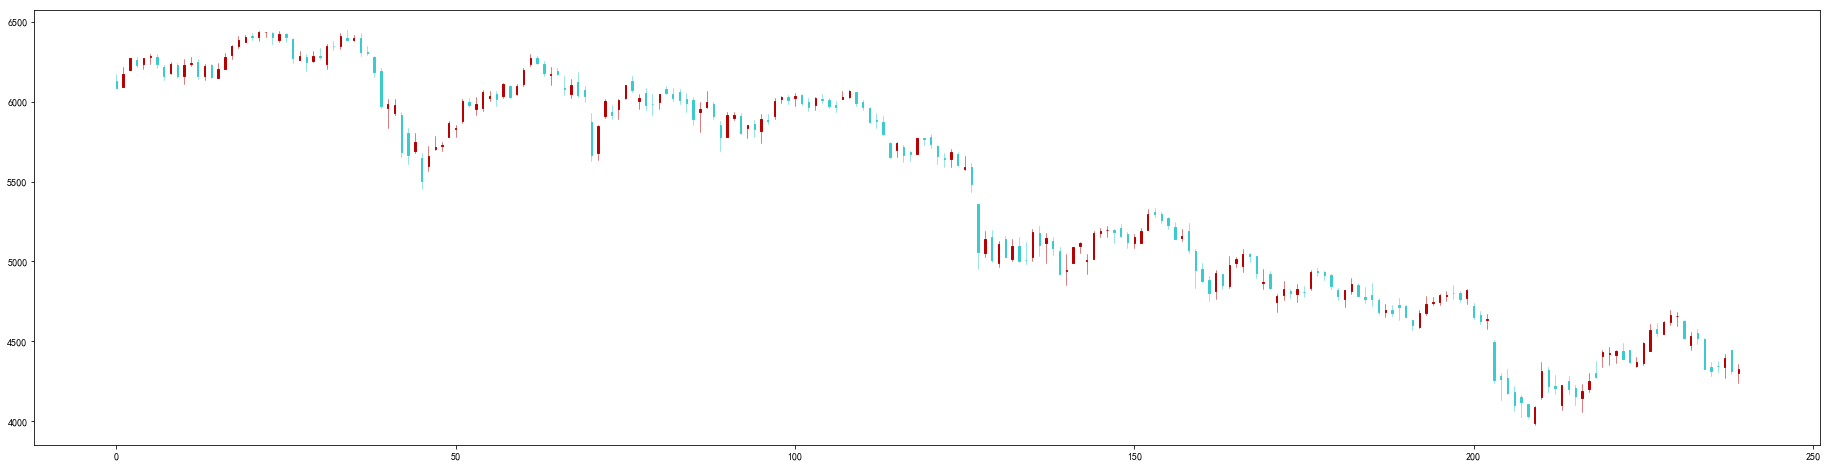

In [15]:
# 参数设置和数据准备
TargetID = "IC00.CFE"

StartDT = dt.datetime(2015, 4, 16)# 回测开始日期
EndDT = dt.datetime(2018, 11, 30)# 回测截止日期

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid="CFFEX", start_dt=StartDT, end_dt=EndDT)
FT = WDB.getTable("中国股指期货日行情")
Price = FT.readData(factor_names=["开盘价(元)", "最高价(元)", "最低价(元)", "收盘价(元)"], ids=[TargetID], dts=DTs).iloc[:, :, 0]
WDB.disconnect();

from QuantStudio.Tools.MatplotlibFun import plotCandleStick
Fig, Axes = plt.subplots(1, 1, figsize=(32, 8))
plotCandleStick(Axes, Price.values[-240:]);

,0
起始时点,2015-04-16 00:00:00
结束时点,2018-11-30 00:00:00
时点数,888
总收益率,-0.0637323
年化收益率,-0.0179908
年化波动率,0.103427
Sharpe比率,-0.173946
胜率,0.936937
最大回撤率,0.23919
最大回撤开始时点,2015-08-25 00:00:00


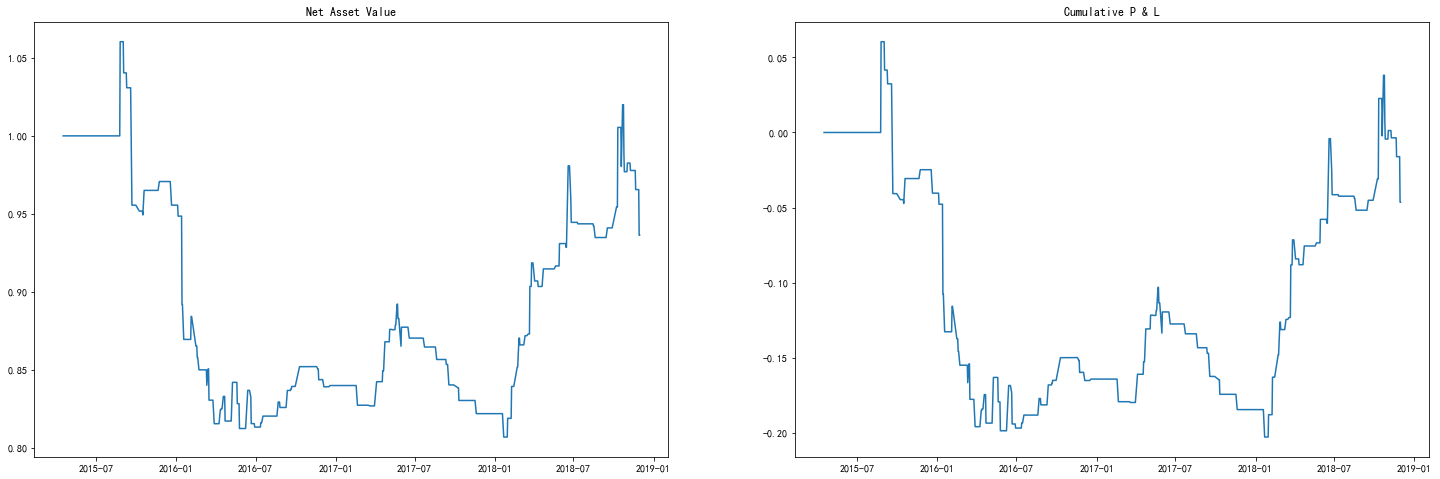

In [16]:
# 缺口动量策略
StdLookBack = 90# 估计标准差的回溯期
EntryThreshold = 0.1# 交易的标准差阈值

C2CReturn = Price.iloc[:, -1] / Price.iloc[:, -1].shift(1) - 1
LongThreshold = (Price.iloc[:, 1] * (1 + EntryThreshold * C2CReturn.rolling(StdLookBack).std())).shift(1)
ShortThreshold = (Price.iloc[:, 2] * (1 - EntryThreshold * C2CReturn.rolling(StdLookBack).std())).shift(1)
Amount = np.zeros(Price.shape[0])
Amount[(Price.iloc[:, 0]>LongThreshold).values] = 1
Amount[(Price.iloc[:, 0]<ShortThreshold).values] = -1

O2CReturn = Price.iloc[:, -1] / Price.iloc[:, 0] - 1
Return = Amount * O2CReturn
Return[pd.isnull(Return) | np.isinf(Return)] = 0
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(Return.cumsum())
Axes[1].set_title("Cumulative P & L");

# References

[<a id="cit-Chan:2013" href="#call-Chan:2013">Chan:2013</a>] Ernest Chan, ``_Algorithmic trading: winning strategies and their rationale_'',  2013.

